# 0. 预处理

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from pathlib import Path
from typing import Optional, List
from torchvision.transforms.v2.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from torchvision.utils import flow_to_image
import pickle
from torchcodec.decoders import VideoDecoder
import cv2
import ot
import tempfile
import open_clip
import imageio
from IPython.display import Video, display
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.features import VideoFeatures, ShotFeatures
from src.eval.metrics import get_saliency_score, get_semantic_score, get_motion_score

In [2]:
def plot(imgs):
    fig, axes = plt.subplots(nrows=len(imgs), ncols=len(imgs[0]), figsize=(len(imgs[0])*3, len(imgs)*2))
    axes = np.array(axes).reshape(len(imgs), len(imgs[0]))
    for i in range(len(imgs)):
        for j in range(len(imgs[i])):
            axes[i][j].imshow(imgs[i][j])
            axes[i][j].axis('off')
    plt.tight_layout(pad=0.5)
    plt.show()

In [3]:
video_dir_path = Path(".") / "../data/videos/BilibiliVideos/cpsfNCZVexQ"
video_path = video_dir_path / "video.mp4"
pkl_dir_path = Path(".") / "../output/videos/BilibiliVideos/cpsfNCZVexQ"
pkl_path = pkl_dir_path / "features.pkl"

decoder = VideoDecoder(video_path)

In [4]:
def get_imgs(clip, frame_type: int):
    if frame_type == 0:
        frame = clip.start_frame
        saliency = clip.start_saliency
        flow = clip.start_flow
    elif frame_type == 1:
        frame = clip.end_frame
        saliency = clip.end_saliency
        flow = clip.end_flow
    else:
        raise ValueError()
        
    sim = Image.fromarray(saliency*255).convert('RGB')
    sim = sim.resize((decoder.metadata.width, decoder.metadata.height),resample=Image.BILINEAR)
    fim = Image.fromarray(flow_to_image(torch.tensor(flow)).permute(1, 2, 0).numpy()).convert('RGB')
    fim = fim.resize((decoder.metadata.width, decoder.metadata.height),resample=Image.BILINEAR)
    return [to_pil_image(decoder[frame]), sim, fim]

In [5]:
def show_clips(clips, fps = None):
    if not fps:
        fps = decoder.metadata.average_fps
    all_frames = []
    for clip in clips:
        all_frames.extend(decoder[clip.start_frame : clip.end_frame + 1])

    frames_tensor = torch.stack(all_frames)
    
    frames_np = frames_tensor.permute(0, 2, 3, 1).cpu().numpy()

    imageio.mimwrite("temp_video.mp4", frames_np, fps=fps, quality=8, macro_block_size=None)
    
    # 展示视频
    display(Video("temp_video.mp4", embed=True, width=300))

# 1. 获取数据

In [6]:
with open(pkl_path, 'rb') as f:
    features = pickle.load(f)

clips = []
for curr_shot in features.shots:
    clips.append(features.get_shot_features(curr_shot["start"], curr_shot["end"]))

# 2. 分析

## 2.1 构图相似

In [23]:
total = 0
for i in range(10):
    Sum = []
    idx_ord = list(range(0, len(clips)))
    import random
    random.shuffle(idx_ord)
    for i in range(1, len(clips)):
        Sum.append(get_saliency_score(clips[idx_ord[i-1]].end_saliency, clips[idx_ord[i]].start_saliency))
    Sum = sorted(Sum, reverse=True)
    total += sum(Sum) / len(Sum)

print(total / 10)

0.80573577


In [22]:
similarities = [(i, get_saliency_score(clips[i].end_saliency, clips[i + 1].start_saliency)) for i in tqdm(range(len(clips) - 1))]
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
print(sum([x[1] for x in similarities]) / len(similarities))

100%|██████████| 394/394 [00:00<00:00, 26648.97it/s]

0.8105355


86 0.96023124


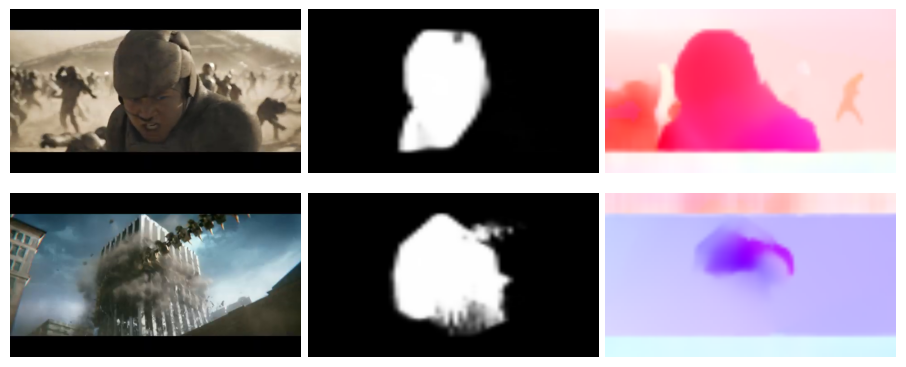

In [31]:
ith = 7
idx, score = similarities[ith]
print(idx, get_saliency_score(clips[idx].end_saliency, clips[idx+1].start_saliency))
plot([get_imgs(clips[idx], 1), get_imgs(clips[idx + 1], 0)])

## 2.2 语义相似

In [15]:
Sum = []
idx_ord = list(range(0, len(clips)))
import random
random.shuffle(idx_ord)
for i in range(1, len(clips)):
    Sum.append(get_semantic_score(clips[idx_ord[i-1]].clip_embed, clips[idx_ord[i]].clip_embed))
Sum = sorted(Sum, reverse=True)
# print(Sum[int(len(Sum) * 0.2)])
print(sum(Sum) / len(Sum))

0.7417424


In [14]:
similarities = [(i, get_semantic_score(clips[i].clip_embed, clips[i + 1].clip_embed)) for i in range(len(clips) - 1)]
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
print(sum([x[1] for x in similarities]) / len(similarities))

0.79721975


22 0.91506726


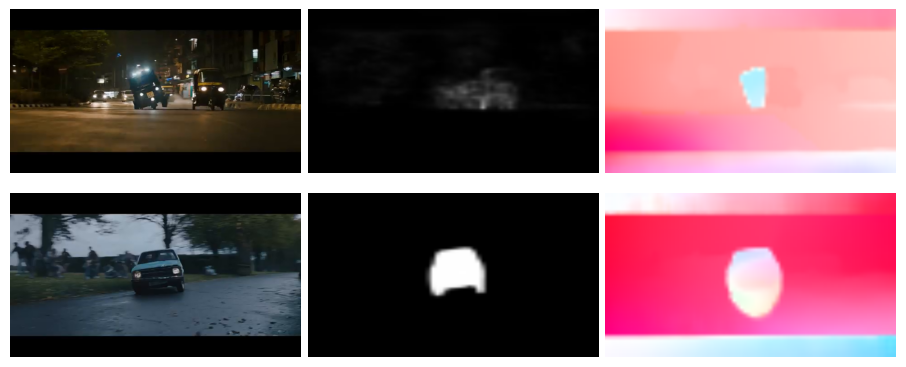

In [13]:
ith = 100
idx, score = similarities[ith]
idx = 22
print(idx, get_semantic_score(clips[idx].clip_embed, clips[idx+1].clip_embed))
plot([get_imgs(clips[idx], 1), get_imgs(clips[idx + 1], 0)])

## 2.3 运动相似

In [11]:
def _extract_top_flows(flow_field, top_ratio):
    u = flow_field[0].reshape(-1)
    v = flow_field[1].reshape(-1)
    mag = np.sqrt(u**2 + v**2)
    k = max(1, int(len(mag) * top_ratio))
    idx = np.argpartition(mag, -k)[-k:]
    top_u = u[idx]
    top_v = v[idx]
    return (np.mean(top_u), np.mean(top_v))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
def get_motion_score(clip1, clip2, top_ratio=0.05):    
    (u1, v1) = _extract_top_flows(clip1, top_ratio)
    (u2, v2) = _extract_top_flows(clip2, top_ratio)
    m1 = np.sqrt(u1**2+v1**2)
    m2 = np.sqrt(u2**2+v2**2)
    mag_sim = 1 - np.tanh(np.abs(m1 - m2) / 80.0)
    dir_sim = np.abs((u1 * u2 + v1 * v2) / (m1 * m2))
    # dir_conf = sigmoid((m1 - 8) / 2) * sigmoid((m2 - 8) / 2)
    dir_conf = (m1 / (m1 + 2)) * (m2 / (m2 + 2))
    # dir_conf = 1 - np.exp(-m1 * m2 / 500)
    print(u1, v1, u2, v2)
    print(m1, m2)
    print(mag_sim, dir_sim, dir_conf)
    return mag_sim * (1 - dir_conf) + dir_sim * dir_conf

In [10]:
cnt = 10
total = 0
for i in range(cnt):
    Sum = []
    idx_ord = list(range(0, len(clips)))
    import random
    random.shuffle(idx_ord)
    for i in range(1, len(clips)):
        Sum.append(get_motion_score(clips[idx_ord[i-1]].end_flow, clips[idx_ord[i]].start_flow))
    Sum = sorted(Sum, reverse=True)
    total += sum(Sum) / len(Sum)

print(total / cnt)


0.6914387


In [7]:
similarities = [(i, get_motion_score(clips[i].end_flow, clips[i + 1].start_flow)) for i in range(len(clips) - 1)]
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

print(sum([x[1] for x in similarities]) / len(similarities))

0.73325694


22 0.98085064


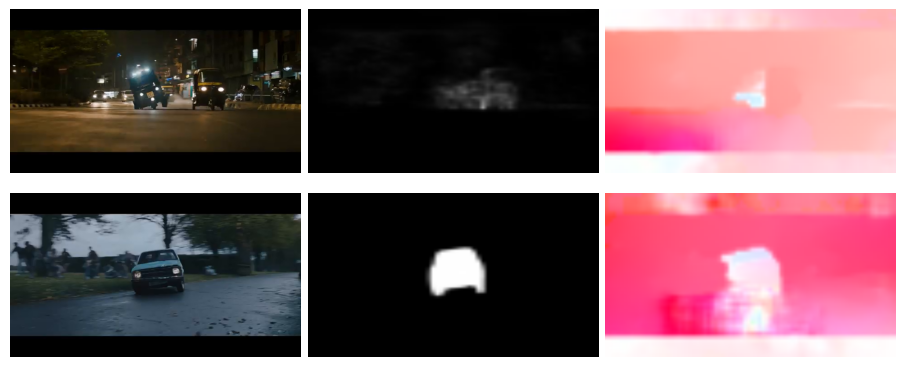

In [11]:
ith = 24
(idx, sim) = similarities[ith]
idx = 22
print(idx, get_motion_score(clips[idx].end_flow, clips[idx + 1].start_flow))
plot([get_imgs(clips[idx], 1), get_imgs(clips[idx + 1], 0)])
show_clips([clips[idx], clips[idx + 1]], fps=30)